# Decision Trees and Random Forests - Loan Project

Goals: use decision trees and random forests models to classify and predict whether or not the borrower paid back their loan in full.

Dataset: [lending data from 2007-2010](https://www.lendingclub.com/info/download-data.action) from Lending Club, which connects people who need money (borrowers) with people who have money (investors). 


Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get the Data
loans = pd.read_csv('loan_data.csv')

In [3]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
credit.policy        9578 non-null int64
purpose              9578 non-null object
int.rate             9578 non-null float64
installment          9578 non-null float64
log.annual.inc       9578 non-null float64
dti                  9578 non-null float64
fico                 9578 non-null int64
days.with.cr.line    9578 non-null float64
revol.bal            9578 non-null int64
revol.util           9578 non-null float64
inq.last.6mths       9578 non-null int64
delinq.2yrs          9578 non-null int64
pub.rec              9578 non-null int64
not.fully.paid       9578 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [4]:
loans.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [5]:
loans.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


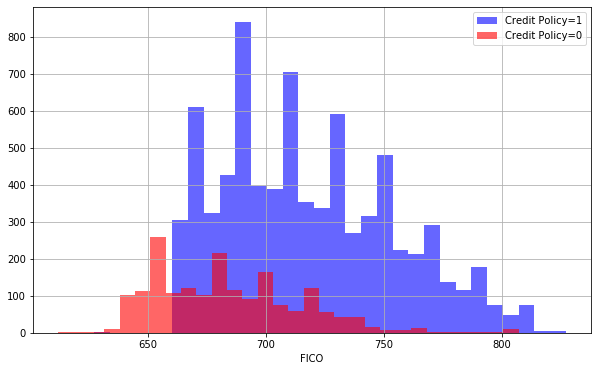

In [7]:
# Exploratory Data Analysis

# Create a histogram of two FICO distributions on top of each other, one for each credit.policy outcome
plt.figure(figsize=(10,6))
loans['fico'][loans['credit.policy']==1].hist(bins=30, color='blue', label='Credit Policy=1', alpha=0.6)
loans['fico'][loans['credit.policy']==0].hist(bins=30, color='red', label='Credit Policy=0', alpha=0.6)
plt.xlabel('FICO')
plt.legend()

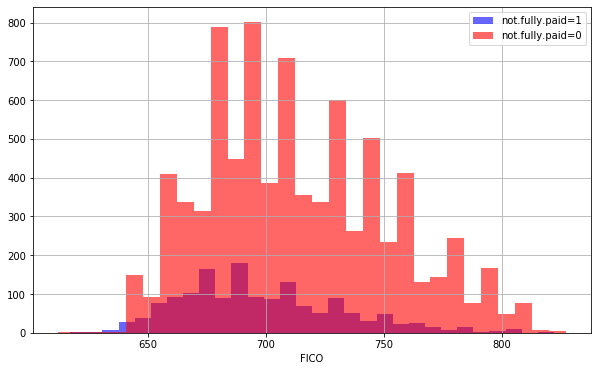

In [8]:
# Create a histogram of two FICO distributions on top of each other, one for each the not.fully.paid column
plt.figure(figsize=(10,6))
loans['fico'][loans['not.fully.paid']==1].hist(bins=30, color='blue', label='not.fully.paid=1', alpha=0.6)
loans['fico'][loans['not.fully.paid']==0].hist(bins=30, color='red', label='not.fully.paid=0', alpha=0.6)
plt.xlabel('FICO')
plt.legend()

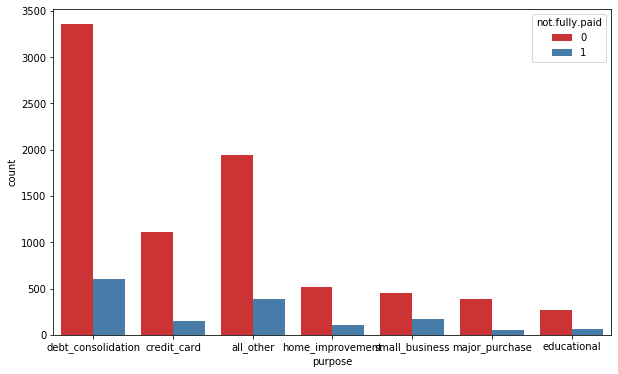

In [9]:
# Create a countplot showing the counts of loans by purpose, with the color hue defined by not.fully.paid. 
plt.figure(figsize=(10,6))
sns.countplot(x='purpose', data=loans, hue='not.fully.paid', palette='Set1')
# plt.tight_layout()

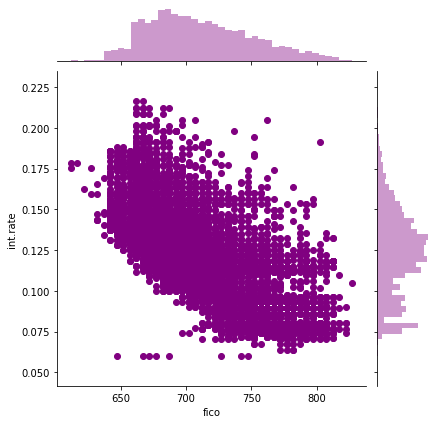

In [10]:
# Check the trend between FICO score and interest rate.
sns.jointplot(x='fico', y='int.rate', data=loans, color='purple')

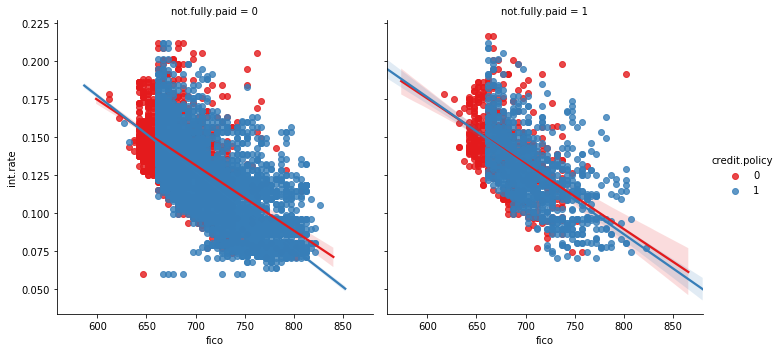

In [11]:
# Create lmplots to see if the trend differed between not.fully.paid and credit.policy.
sns.lmplot(x='fico', y='int.rate', data=loans, col='not.fully.paid', hue='credit.policy', palette='Set1')

In [12]:
# Set up data for Random Forest Classification Model

# Create a list of 1 element containing the string 'purpose'. 
cat_feats = ['purpose']  # list of categorical features

In [13]:
# transform categorical variable using dummy variables 
final_data = pd.get_dummies(data=loans, columns=cat_feats, drop_first=True) 
# drop_first=True to avoid multi-collinearity issues

In [14]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 19 columns):
credit.policy                 9578 non-null int64
int.rate                      9578 non-null float64
installment                   9578 non-null float64
log.annual.inc                9578 non-null float64
dti                           9578 non-null float64
fico                          9578 non-null int64
days.with.cr.line             9578 non-null float64
revol.bal                     9578 non-null int64
revol.util                    9578 non-null float64
inq.last.6mths                9578 non-null int64
delinq.2yrs                   9578 non-null int64
pub.rec                       9578 non-null int64
not.fully.paid                9578 non-null int64
purpose_credit_card           9578 non-null uint8
purpose_debt_consolidation    9578 non-null uint8
purpose_educational           9578 non-null uint8
purpose_home_improvement      9578 non-null uint8
purpose_major_purchase        9

In [15]:
final_data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [16]:
# Train Test Split
from sklearn.model_selection import train_test_split

In [17]:
X = final_data.drop('not.fully.paid', axis=1)
y = final_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [18]:
# Training a Decision Tree Model

from sklearn.tree import DecisionTreeClassifier

In [19]:
dtree = DecisionTreeClassifier()

In [20]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
# Predictions and Evaluation of Decision Tree

In [22]:
dpred = dtree.predict(X_test)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
print(classification_report(y_test, dpred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2431
           1       0.19      0.23      0.21       443

    accuracy                           0.73      2874
   macro avg       0.52      0.52      0.52      2874
weighted avg       0.75      0.73      0.74      2874



In [25]:
print(confusion_matrix(y_test, dpred))

[[1995  436]
 [ 342  101]]


In [26]:
# Training the Random Forest model

from sklearn.ensemble import RandomForestClassifier

In [27]:
rfc = RandomForestClassifier(n_estimators=300)

In [28]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
# Predictions and Evaluation
rfc_pred = rfc.predict(X_test)

In [30]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2431
           1       0.53      0.02      0.04       443

    accuracy                           0.85      2874
   macro avg       0.69      0.51      0.48      2874
weighted avg       0.80      0.85      0.78      2874



In [31]:
print(confusion_matrix(y_test, rfc_pred))

[[2422    9]
 [ 433   10]]


In [32]:
# decision tree did better on class 1 for recall (0.22 vs. 0.02) and f1-score (0.22 vs.0.03)
# overall, random forest performs better